#Ερώτημα 1

1.1

Αρχικά γίνεται unzip το αρχείο με τις εικόνες το οποίο περιέχει τα δεδομένα αυτής της άσκησης το οποίο για λόγους ευκολίας έχω ανεβάσει το drive μου. Επίσης κάνω import όσες βιβλιοθήκες θα χρειαστούν για την ορθή λειτουργία της εργασίας.

In [ ]:
#Import pandas to load the csv dataset
import pandas as pd
import re as re
import math
import matplotlib.pyplot as plt
import time
import numpy as np
import numpy.linalg as LA
import cv2
from sklearn import decomposition as decomposition
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#Libraries to get access to files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Load the images dataset
link = 'https://drive.google.com/file/d/open?id=1IWuU1npNm0g0Imp0DQfvvPgkBobkkYXc'
fluff, id_data = link.split('=')
downloaded = drive.CreateFile({'id':id_data})
downloaded.GetContentFile('images.zip')
!unzip 'images.zip'

Οι συναρτήσεις στο παρακάτω κελί κώδικα απαντούν στο πρώτο υποερώτημα της άκσησης αυτής. Η συνάρτηση `get_image_label()` επιστρέφει [0,1,2] ανάλογα με το όνομα της εικόνας για να έχουμε τα ορθά labels στο dataset μας. Συγκεκριμένα το 0 αντιστοιχεί στο Χειμώνα, το 1 στο Φθινόπωρο και το 2 στην Άνοιξη. Η συνάρτηση `loadImages()` όπως μας ζητήθηκε από την εκφώνηση δέχεται το path στο οποίο βρίσκονται οι φωτογραφίες, τις φορτώνει στη μνήμη με τη χρήση της βιβλιοθήκης cv2, της κάνει resize σε 100x100 ( και κρατάει ένα δεύτερο set απο τισ εικόνες στη μνήμη μεγέθους 50x50 για κάποιο ζητήμα που προκύψαν στα παρακάτω ερωτήματα ), βρίκσει τα κατάλληλα labels και τελικά επιστρέφει το dataset με τα label του.

In [ ]:
def get_image_label(image_name):
  if (image_name[0]=='W'):
    return 0
  elif (image_name[0]=='F'):
    return 1
  else:
    return 2

def loadImages(path):

  #Initialize the input data as an empty list
  X=[]
  #Initialize the scaled input data on a smaller scale (50x50)
  X_50=[]
  #Initialize the labels as an empty list
  labels=[]
  for filename in os.listdir(path):
    labels.append(get_image_label(filename))
    #Load the image using cv2 library
    img = cv2.imread(path+filename)
    #Resize the image to 100x100
    img = cv2.resize(img,(100,100))
    img_50 = cv2.resize(img,(50,50))
    #Cv2 uses bgr representation for coloured images
    #Revert the arrays to rgb for better use
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_50 = cv2.cvtColor(img_50, cv2.COLOR_BGR2RGB)
    X.append(img)
    X_50.append(img_50)
  X=np.array(X)
  X_50=np.array(X_50)
  return X,X_50,labels

1.2

Για την PCA έχουμε τα εξής :

Τα παρακάτω κελιά απαντούν στο δεύτερο υποερώτημα της άσκησης. Αρχικά υλοποίησα την συνάρτηση `myPCA()`, η οποία κάνει τη διαδικασία της PCA για τα δεδομένα X, επιστρέφοντας τα δεδομένα μετασχηματισμένα με βάση της k κύριες συνιστώσες. Ο κώδικας της συνάρτησης αυτής είναι κατα κύριο λόγο ο κώδικας που μας δόθηκε στο φροντιστήριο του μαθήματος με μερικές αλλαγές ώστε η συνάρτησή μου να συμβαδίζει με την PCA της sklearn όσον αφορά τα αποτελέσμετα. Συγκεκριμένα, στα πλαίσια της άσκησης άλλαξα τα dim με τα samplesNum ώστε να συμφωνούν οι διαστάσεις των αποτελεσμάτων και ο μετασχηματισμός της PCA να οδηγεί σε ενα αποτελέσμα της μορφής (2,30) αντί για (2,100) αν υποθέσουμε ότι αρχικά το Χ είχε διαστάσεις (30,100) και k=2. Επιπλέον για μεγαλύτερη ακρίβεια υλοποίησα την διαδικασία η οποία υπολογίζει τον πίνακα συνδιακύμανσης (covariance matrix). Ο πίνακας σκέδης (scatter matrix) μπορεί ακόμα να χρησιμοποιηθεί να το όρισμα `calculate_cov=False`. Στη συνέχεια για την ταξινόμηση χρησιμοποίησα την argsort της numpy για μεγαλύτερη ταχύτητα και ακρίβεια στην ταξινόμηση. Αφού επιλεγούν οι k κύριες συνιστώσες γίνεται ο πολλαπλασιασμός με το αρχικό Χ από το οποίο έχει αφαιρεθεί το μέσο του πίνακα (meanVector). Στο τέλος το αποτελέσμα επιστρέφεται σε ανάστροφη μορφή του πίνακα. Η παραπάνω διαδικασία κάνει επιτυχώς την διαδικασία PCA.

>Η συνάρτηση `PCA_ImageSpaceVisualization()` η οποία ζητήθηκε από την εκφώνηση καλεί την PCA για τον μετασχηματισμό των δεδομένων. Να σημειωθεί ότι αρχικά τα δεδομένα έχουν μέγεθος (30,100,100,3). Για να εφαρμοστεί η PCA πρέπει τα δεδομένα που αναπαριστούν κάθε εικόνα από (100,100,3) να μετασχηματιστούν σε (30000,) για να λειτουργήσει η PCA. Άρα το μέγεθος του input της PCA θα είναι (30,30000) και εφόσον θα επιλέξουμε k=2 συνιστώσες το αναμένουμε το αποτέλεσμα να είναι (30,2). Στη συνέχεια τυπώνουμε κάθε σημείο του αποτελέσματος με την εικόνα που του αντιστοιχεί για να δημιουργήσουμε το plot που ζητείται στην εκφώνηση.


In [ ]:
#Function to perform a PCA on a given input keeping the k best components
def myPCA(X,k,calculate_cov=False):

  dim=X.shape[0]
  samplesNum=X.shape[1]

  #Calculate the mean of X
  meanVector = []
  for i in range(samplesNum):
    meanVector.append(np.mean(X[:,i]))
  meanVector = np.array(meanVector)

  cov=[]
  #If calculate_cov is false then calculate the scatter matrix
  #and use its eigenvalues and eigenvectors for the component analysis
  if calculate_cov==False :
    scatterMat = np.zeros((samplesNum,samplesNum))
    for i in range(dim):
        scatterMat += ((X[i,:].reshape(samplesNum,1) - meanVector)).dot((X[i,:].reshape(samplesNum,1) - meanVector).T)
    cov = scatterMat
  #Calculate the covariance matrix
  else:
    cov = np.dot((X-meanVector).T, (X-meanVector))/(dim-1)

  #Get the eigen values
  eigValue, eigVector = np.linalg.eigh(cov)

  index = np.argsort(eigValue)[::-1]
  selectededEigenValues = eigValue[index]
  selectededEigenVectors = eigVector[:,index]

  w = selectededEigenVectors[:,0:k]
  XAllTrans = w.T.dot((X-meanVector).T)
  return XAllTrans.T


def PCA_ImageSpaceVisualization(Χ):
  x_points=[]
  y_points=[]
  pca = decomposition.PCA(2)
  X_flat = X.reshape(30,-1)
  components = pca.fit_transform(X_flat)
  count=0
  for i in range(30):
    count+=1
    x_points+=[components[i][0]]
    y_points+=[components[i][1]]
    print(str(count)+"/"+str((X.shape[0]))+"  Component taken as point x:"+str(components[i][0])+" y:"+str(components[i][1]))

  fig, ax = plt.subplots(figsize=(20,15))
  ax.scatter(x_points, y_points)

  for x0, y0, x in zip(x_points,y_points,X):
    ab = AnnotationBbox(OffsetImage(x), (x0, y0), frameon=False)
    ax.add_artist(ab)

Σε αυτό το κελί κώδικα γίνεται η φόρτωση των δεδομένων. Επειδή η χειροκίνητη υλοποίηση της PCA στη συνάρτηση `myPCA()` <<κρασάρει>> λόγο μνήνης στα δεδομένα με μέγεθος 100x100 , χρησιμοποίησα τα δεδομένα σε μέγεθος 50x50 και σύγκρινα τα αποτελέσματα της δικιάς μου PCA με την PCA της sklearn ενώ για το γράφημα χρησιμοποίησα την PCA της sklearn η οποία μπορεί να χειριστεί τα δεδομένα σε μορφή 100x100 ώστε το plot να είναι σωστό, όπως προτάθηκε στο μάθημα. Παρατηρούμε παρακάτω λοιπόν ότι η δικιά μου PCA έχει τα ίδια αποτελέσματα με την PCA της sklearn.

In [ ]:
path = "images/"
X,X_50,labels = loadImages(path)
#Compare the PCA I create and sklearn's PCA
#on the data scaled to (50x50)
X_50 = X_50.reshape(30,-1)
my_components = myPCA(X_50,2,True)
pca = decomposition.PCA(2)
components = pca.fit_transform(X_50)
print("My components : ")
print(my_components)
print("-----------------")
print("Sklearn's components : ")
print(components)

Σε αυτό το κομμάτι κωδικα καλείται η `PCA_ImageSpaceVisualization()` για τη δημιουργία του plot. To plot έχει την μορφή την οποία περιμέναμε από την εκφώνηση.

In [ ]:
PCA_ImageSpaceVisualization(X)

1.3

Η απόσταση των εικόνων στο plot σημαίνει ότι τα δεδομένα τους ήταν παρόμοια στην αρχική τους μορφή. Συγκεκριμένα παρατηρούμε ότι τα χρώματα που είναι παρόμοια βρίσκονται πιο κοντά το ένα στο άλλο σε αντίθεση με πιο ανόμοια χρώματα (πχ άνοιξη-χειμώνας). Αυτό οφείλεται στο γεγονός ότι οι αρχικοί πίνακες που αναπαριστούν τα τρία κανάλια για τα χρώματα θα έχουν παρόμοια δεδομένα για εικόνες με παρόμοια χρώματα. Επομένως όταν γίνει η επιλογή των 2 κυρίων συνιστωσών η ιδιότητα αυτή των εικόνων αντικατοπτρίζεται και στον δισδιάστατο χώρο. Συνεπώς εικόνες με διαφορετικά χρώματα και άρα σχετικά διαφορετικές αναπαραστάσεις στα δεδομένα τους θα μεγάλη απόσταση στο δισδιάστατο χώρο.

1.4

Παρόμοια με το παραπάνω ερώτημα οι εικόνες πχ του χειμώνα που έχουν πολύ διαφορετικά χρώματα από το υπόλοιπο dataset φαίνεται να είναι όλες πολυ κοντά η μια με την άλλη. Αυτό οφείλεται στο γεγονός που εξηγήθηκε στο παραπάνω ερώτημα με την αναπαράσταση των δεδομένων στα τρια κανάλια για τα χρώματα. Επομένως είναι φυσικό αν οι εικόνες έχουν κοντινά διανύσματα στην πλήρη αναπαράστασή τους είναι λογικό και στο δισδιάστατο χώρο να βρίσκονται κόντα η μια στην άλλη και να τείνουν να ομαδοποιούνται. Αυτό είναι πολύ προφανές με τις εικόνες του χειμώνα και κάπως πιο ασαφές με τις εικόνες της άνοιξης και του φθινοπώρου που τα χρώματά τους δεν απέχουν τόσο πολύ.

1.5

Ταξινόμηση των αποτελεσμάτων με τη χρήση του αλγορίθμου των K-πλησιέστερων γειτόνων. Η συνάρτηση που υλοποιεί την ταξινόμηση είναι η συνάρτηση που υλοποίησα `K_neighbors_image_classification()` . Αυτή η συνάρτηση αρχικοποιεί ένα αντικείμενο KNeighborsClassifier και ένα kfold για να υλοποιήση τη διαδικασία. Το kfold αρχικοποιείται με 5 όπως ζητήθηκε από την εκφώνηση. Ο ταξινομητής αρχικοποίεται με k το οποίο δίνεται από σαν όρισμα στη συνάρτηση. Στη συνέχεια γίνεται η διαδικασία του cross validation και υπολογίζεται το μέσω accuracy το οποίο και τυπώνεται.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Function to return the data after PCA
def get_data_from_PCA(X,k):
  new_X=[]
  pca = decomposition.PCA(k)
  pca.fit(X)
  new_X = pca.transform(X)
  return new_X

#Function to get the accuracy of the predicted outputs
def get_accuracy(y,y_pred):
  n = len(y)
  count=0
  for i in range(len(y)):
    if y[i]==y_pred[i]:
      count+=1
  return float(count/n)

"""A function used to implement a classification
based on sklearn's KNeighborsClassifier along
with sklearn's kfold to perform a 5-fold
cross validation on the learning procudre """
def K_neighbors_image_classification(X,y,k):
  #Initialize a kfold object
  kf = KFold(n_splits=5)
  #Initialize the KNeighborsClassifier
  model = KNeighborsClassifier(n_neighbors=k)

  X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3,random_state=42)

  #Pefrom the algorithm
  index=0
  scores=[]
  for train_index, test_index in kf.split(X_tr,y_tr):
    #Get the spli data from kflod
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Train the model with the train data
    model.fit(X_train,y_train)
    #Get the predictions
    y_pred = model.predict(X_test)
    scores.append(get_accuracy(y_test,y_pred))
    index+=1
  print("Mean Accuracy on training: "+str(sum(scores)/5))
  y_pred = model.predict(X_te)
  print("Accuracy on test set after training: "+str(get_accuracy(y_te,y_pred)))



1.5.1

Στο παρακάτω κελί γίνεται η κλήση της συνάρτησης για την ταξινόμηση. Αρχικά καλείται χωρίς τον μετασχηματισμό της PCA για 1 και 3 γείτονες. Στη συνέχεια καλείται με τον μετασχηματισμό της PCA για k=18 συνιστώσες πάλι για 1 και 3 γείτονες. Παρατητούμε λοιπόν ότι τα αρχικά δεδομένα με τα μετασχηματισμένα έχουν την ίδια απόδοση ή καλύτερη απόδοση. Αυτό για πολύ περισσότερα δεδομένα θα είχε πολύ σημαντική απόδοση στο χρόνο ή για δεδομένα τα οποίο είναι πιο διάσπαρτα από ότι εικόνες. Επίσης οφείλεται στο γεγονός ότι ο ταξινομητής των πλησιέστερων γειτόνων συγκρίνει δεδομένα στο δισδιάστατο χώρο, άρα όσο μιρκότερη η αρχική διάσταση των δεδομένων και άρα και το μέγεθός τους σε μορφή διανύσματος τόσο πιο αποτελεσματικός θα είναι ο αλγόριθμος.
>Το 1-ΝΝ βλέπουμε ότι έχει ίδια αποτελέσματα με το 3-ΝΝ κατα τη διάρκεια της εκπαίδευσης. Παρατηρούμε όμως ότι όταν ελέγχουμε το test set η απόδοσή του μειώνεται διότι ο 1-ΝΝ τίνει να κάνει overfit στο training set όπως γνωρίζουμε από τη θεωρία.

In [ ]:
print("Data without PCA transformation:")

#Run the algorithm for 1 neighbor
print("1-NN:")
X_for_training = X.reshape(30,30000)
y = np.array(labels)
K_neighbors_image_classification(X_for_training,y,1)

#Run the algorithm for 3 neighbors
print("3-NN:")
K_neighbors_image_classification(X_for_training,y,3)
print("-----------------------")


#Get the top k components and run the algorithm with the new data
print("Data with PCA transformation:")
X_for_training = X.reshape(30,30000)
X_for_training = get_data_from_PCA(X_for_training,18)
#Run the algorithm for 1 neighbor
print("1-NN:")
K_neighbors_image_classification(X_for_training,y,1)
#Run the algorithm for 3 neighbors
print("3-NN:")
K_neighbors_image_classification(X_for_training,y,3)
print("-----------------------")

Data without PCA transformation:
1-NN:
Mean Accuracy on training: 0.72
Accuracy on test set after training: 0.8888888888888888
3-NN:
Mean Accuracy on training: 0.72
Accuracy on test set after training: 1.0
-----------------------
Data with PCA transformation:
1-NN:
Mean Accuracy on training: 0.77
Accuracy on test set after training: 0.8888888888888888
3-NN:
Mean Accuracy on training: 0.77
Accuracy on test set after training: 1.0
-----------------------


1.5.2

Για την επιλογή του αριθμού των κύριων συνιστωσών υλοποίηση την συνάρτηση στο παρακάτω κελί κώδικα. Η συνάρτηση αυτή υπολογίζει τις ιδιοτιμές του πίνακα συνδιακύμανσης και στη συνέχεια υπολογίζει για την κάθε ιδιοτιμή $\lambda_i$ το παρακάτω : $\frac{\lambda_i}{\lambda_1 + \lambda_2 + ... \lambda_n}$ και τα αποθηκεύει. Αφού γίνει αυτός ο υπολογισμός επιστρέφει όλα τα αποτελέσματα σε έναν numpy array.

In [ ]:
def my_pca_explained_variance_ratio(X,k):
  explained_variance_ratio=[]
  dim=X.shape[0]
  samplesNum=X.shape[1]
  meanVector = np.mean(X,axis=0)
  cov = np.dot((X-meanVector).T, (X-meanVector))/(dim-1)

  #Get the eigen values
  eigValue, eigVector = np.linalg.eigh(cov)

  index = np.argsort(eigValue)[::-1]
  selectededEigenValues = eigValue[index]
  selectededEigenVectors = eigVector[:,index]

  selectededEigenValues = abs(selectededEigenValues)
  list_sum = sum(selectededEigenValues)
  for i in range(k):
    explained_variance_ratio.append(selectededEigenValues[i]/(list_sum))

  return np.array(explained_variance_ratio)



Για την σύγκριση των αποτελεσμάτων χρησιμοποίησα τα δεδομένα σε μέγεθος 50x50 και βλέπουμε ότι η συναρτησή μου έχει ορθά αποτελέσματα.

In [ ]:
pca = decomposition.PCA(20)
pca.fit(X_50)
new_X = pca.transform(X_50)
print("My exlpained variance ratio: ")
print(my_pca_explained_variance_ratio(X_50,20))
print("------------------------------")
print("Sklearn's exlpained variance ratio: ")
print(pca.explained_variance_ratio_)

My exlpained variance ratio: 
[0.49440505 0.09643638 0.06057175 0.04807374 0.03768706 0.03169899
 0.02593779 0.02323269 0.0183298  0.01659409 0.01570432 0.01399692
 0.01212066 0.01079611 0.01046809 0.00935343 0.00892967 0.00835396
 0.00788499 0.00748613]
------------------------------
Sklearn's exlpained variance ratio: 
[0.49440505 0.09643638 0.06057175 0.04807374 0.03768706 0.03169899
 0.02593779 0.02323269 0.0183298  0.01659409 0.01570432 0.01399692
 0.01212066 0.01079611 0.01046809 0.00935343 0.00892967 0.00835396
 0.00788499 0.00748613]


Η επιλογή των k=18 συνιστωσών έγινε με τη βοήθεια του κώδικα του εργαστηρίου. Για τα δεδομένα μεγέθους 100x100 χρησιμοποίησα τη βιβλιοθήκη sklearn και την PCA για τον ίδιο λόγο με το πρώτο ερώτημα. Η συνάρτηση μου για δεδομένα μεγέθους 100x100 κρασάρει. Αφού λοιπόν απέδιεξα την εγκυρότητα της συνάρτησής μου παραπάνω έχουμε τα παρακάτω. Με τον κώδικα λοιπόν του εργαστηρίου παρατηρούμε ότι με k=18 συνιστώσες έχουμε λίγο παραπάνω από το 90% το δεδομένων, άρα μπορούμε να χρησιμποιήσουμε αυτές σε αντίθεση με το αρχικό dataset.

[0.46443544 0.09279369 0.05887231 0.04801457 0.03897304]
[0.46443544 0.09279369 0.05887231 0.04801457 0.03897304 0.03279584
 0.02771126 0.02472192 0.01983224 0.01804814 0.01712622 0.01576069
 0.01372996 0.01266584 0.01174871 0.01096085 0.01053376 0.00989092
 0.00962919 0.0087183  0.00865799 0.00761071 0.00740141 0.00737079
 0.00687286 0.00545976 0.00488108 0.00466748]
----------
[0.46443544 0.55722912 0.61610143 0.664116   0.70308904 0.73588488
 0.76359614 0.78831806 0.8081503  0.82619844 0.84332465 0.85908535
 0.87281531 0.88548115 0.89722986 0.90819071 0.91872447 0.92861539
 0.93824458 0.94696288 0.95562087 0.96323158 0.97063299 0.97800378
 0.98487665 0.99033641 0.99521748 0.99988497]


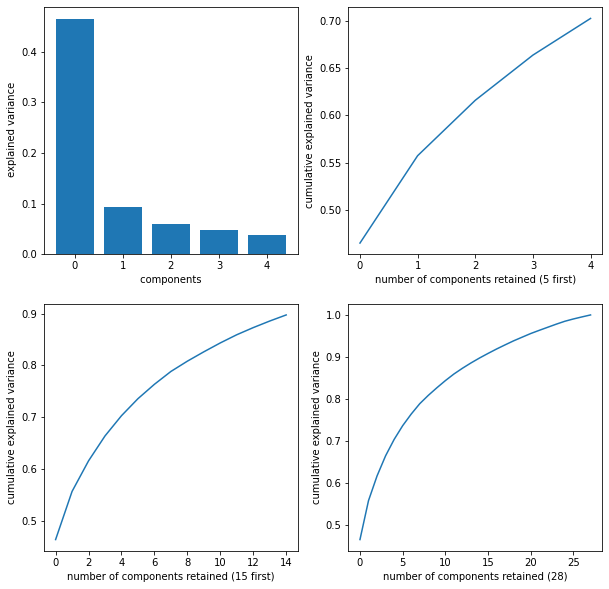

In [ ]:
X_for_training = X.reshape(30,-1)
pca = decomposition.PCA(28)
pca.fit(X_for_training)
new_X = pca.transform(X_for_training)

print (pca.explained_variance_ratio_[:5])

cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print("----------")
print(cumExplainedVar)

plt.figure(figsize=(10, 10))
numOfComp=5
plt.subplot(2, 2, 1)
plt.bar(range(numOfComp),pca.explained_variance_ratio_[:numOfComp])
plt.xlabel(' components ')
plt.ylabel(' explained variance');


plt.subplot(2, 2, 2)
plt.plot(cumExplainedVar[:5])
plt.xlabel('number of components retained (5 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 3)
plt.plot(cumExplainedVar[:15])
plt.xlabel('number of components retained (15 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 4)
plt.plot(cumExplainedVar)
plt.xlabel('number of components retained (28)')
plt.ylabel('cumulative explained variance');

plt.show()


#Ερώτημα 2
2.1

Με τη βοήθεια του Matrix Cookbook για τον γρηγορότερο υπολογισμό των πράξεων έχουμε τα εξής για το πρόβλημα βελτιστοποίησης για την κανονικοποιημένη μη-αρνητική παραγοντοποίηση πινάκων $min||X - AB||^{2}_F + \lambda||A||^{2}_F$:

$min||X - AB||^{2}_F + \lambda||A||^{2}_F = Tr((X-AB)^{T}(X-AB))+ \lambda Tr(A^{T} A) = Tr((X^{T}-B^{T}A^{T})(X-AB))+ \lambda Tr(A^{T} A) = Tr(X^T X - B^T A^T X - X^T A B + B^T A^T A B) + \lambda Tr(A^{T} A) =
Tr(X^T X) - Tr(B^T A^T X) - Tr(X^T A B) + Tr(B^T A^T A B) + Tr(\lambda A^{T} A)$

Αν παραγοντοποίησουμε κάθε έναν από τους παράπανω όρους ως προς τον πίνακα Α έχουμε :

$\nabla_A Tr(X^T X) = 0$
<br>
$\nabla_A Tr(X^T A B) = X B^T$
<br>
$\nabla_A Tr(B^T A^T X) = X B^T$
<br>
$\nabla_A Tr(B^T A^T A B) = 2A B B^T$
<br>
$\nabla_A Tr(\lambda A^T A) = 2\lambda A$

Συνεπώς έχουμε ότι :
<br>
$\nabla_A f(A,B) = -2X B^T + 2 A B B^T + 2\lambda A$

Παρόμοια αν παραγοντοποίησουμε κάθε έναν από τους παράπανω όρους ως προς τον πίνακα Β έχουμε :

$\nabla_Β Tr(X^T X) = 0$
<br>
$\nabla_Β Tr(X^T A B) = (Χ^Τ Α)^Τ = Α^Τ Χ$
<br>
$\nabla_Β Tr(B^T A^T X) = Α^Τ Χ$
<br>
$\nabla_Β Tr(B^T A^T A B) = 2A^Τ Α Β$
<br>
$\nabla_Β Tr(\lambda A^T A) = 0$

Συνεπώς έχουμε ότι :
<br>
$\nabla_Β f(A,B) = -2Α^Τ Χ + 2A^Τ Α Β$

Από τη θεωρία γνωρίζουμε ότι $\nabla_A f(A,B) = \nabla_A f(A,B)^{+} - \nabla_A f(A,B)^{-} = 2 A B B^T + 2\lambda A -2X B^T$
<br><br>
Άρα έχουμε ότι $\eta_A = \frac{A}{\nabla_A f(A,B)^{+}} = \frac{A}{2 A B B^T + 2\lambda A} $ και τελικά το επαναληπτικό βήμα για το Α γίνεται :
<br><br>
$A = A - \frac{A}{\nabla_A f(A,B)^{+}} * \nabla_A f(A,B) \Leftrightarrow$
<br><br>
$A = A - \frac{A}{2 A B B^T + 2\lambda A} *2 A B B^T + 2\lambda A -2X B^T \Leftrightarrow$
<br><br>
$A = A - \frac{A*(2 A B B^T + 2\lambda A -2X B^T) }{2 A B B^T + 2\lambda A}\Leftrightarrow$
<br><br>
$A = A - \frac{A*(2 A B B^T + 2\lambda A) }{2 A B B^T + 2\lambda A} +  \frac{2X B^T}{2 A B B^T + 2\lambda A} \Leftrightarrow$
<br><br>
$A = A - A + A *\frac{2X B^T}{2 A B B^T + 2\lambda A} \Leftrightarrow$
<br><br>
$A = A *\frac{X B^T}{ A B B^T + \lambda A} $
<br><br>
Με παρόμοια τρόπο λοιπόν καταλήγουμε και στο επαναληπτικό βήμα για το Β το οποίο θα είναι :
<br><br>
$Β = Β *\frac{A^T X}{A^T A B} $ , το οποίο παραμένει ίδιο με την κανονική MNF άρα θεώρησα ότι οι πράξεις για αυτό θα μπορούσαν να παραληφθούν. Άρα οι πολλαπλασιαστικοί κανόνες ανανέωσης για το Α και Β θα είναι :
<br><br>
$A_{[t+1]} = A_{[t]} * \frac{X_{[t]} B_{[t]}^T}{A_{[t]} B_{[t]} B_{[t]}^T + λA_{[t]}}$ και

$B_{[t+1]} = B_{[t]} * \frac{A_{[t]}^T X_{[t]}}{A_{[t]}^T A_{[t]} B_{[t]}}$


2.2

Από τα παραπάνω καταλήγουμε στο ότι σε κάθε βήμα ισχύει :

$A_{[t+1]} = A_{[t]} * \frac{X_{[t]} B_{[t]}^T}{A_{[t]} B_{[t]} B_{[t]}^T + λA_{[t]}}$ και

$B_{[t+1]} = B_{[t]} * \frac{A_{[t]}^T X_{[t]}}{A_{[t]}^T A_{[t]} B_{[t]}}$

Άρα με τη βοήθεια του κώδικα που μας δόθηκε από το φροντηστήριο για την NMF προκύπτει η παρακάτω διαδικασία η οποία υλοποιεί την RegNMF :


In [ ]:
#Function to make every element of a matrix positive
def make_absolute(X):
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      X[i,j]=abs(X[i,j])
  return X


def frobenius_norm(X,A,B):  ## find the error as the distanse
		#error between X and A*B
		error = LA.norm(X - np.dot(A, B))/LA.norm(X)  ##dif between X and AB as the equation
		return error

## update  B
def update_b(X,A,B):
  numerator = np.dot(A.T, X)
  denominator = np.dot(A.T.dot(A), B)
  B *= numerator
  B /= denominator
  return B

## update A
def update_a(X,A,B,l):
  numerator = X.dot(B.T)
  denominator = A.dot(B.dot(B.T)) + l*A
  A *= numerator
  A /= denominator
  return A

##compute nmf for specific rank with
def RegNMF(X,k,l,epsilon):

  X_dim, samples = X.shape

  A = np.random.random((X_dim, k))  ##init

  B = np.random.random((k, samples)) ## init

  frob_error = []

  frob_error_t_minus_1=0

  while True:

        aNew=update_a(X,A,B,l)

        bNew=update_b(X,A,B)

        if frob_error_t_minus_1==0:
          frob_error_t = frobenius_norm(X,aNew,bNew)
          frob_error_t_minus_1=1
        else:
          frob_error_t_minus_1 = frob_error_t
          frob_error_t = frobenius_norm(X,aNew,bNew)

          if (frob_error_t_minus_1 - frob_error_t) <= epsilon:
            break

        frob_error.append(frob_error_t)

  return aNew,bNew,frob_error

Δημιουργία του πίνακα X για τον έλεγχο της RegNMF και κλήση της με τα δεδομένα που ζητούνται από την εκφώνηση. Παρατηρούμε ότι το μέγεθος του k και του e επηρεάζουν σε πολύ μεγάλο βαθμό την σύγκλιση του αλγορίθμου. Όσο πιο μικρό είναι το e τόσο πιο αργά συγκλίνει ο αλγόριθμος και αντίστοιχα για το k.

In [ ]:
W = np.random.random((500, 10))
W = make_absolute(W)
H = np.random.random((10, 500))
H = make_absolute(H)
X = W.dot(H)

l=0.5
k=5
epsilon=0.1
A,B,error = RegNMF(X,k,l,epsilon)
print("k=5 & e=0.1")
print (A.dot(B))
print ("-------")
print (error)
print ("--------")

k=10
epsilon=0.1
print("k=10 & e=0.1")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

k=50
epsilon=0.1
print("k=50 & e=0.1")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

k=5
epsilon=0.01
A,B,error = RegNMF(X,k,l,epsilon)
print("k=5 & e=0.01")
print (A.dot(B))
print ("-------")
print (error)
print ("--------")

k=10
epsilon=0.01
print("k=10 & e=0.01")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

k=50
epsilon=0.01
print("k=50 & e=0.01")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

k=5
epsilon=0.001
A,B,error = RegNMF(X,k,l,epsilon)
print("k=5 & e=0.001")
print (A.dot(B))
print ("-------")
print (error)
print ("--------")

k=10
epsilon=0.001
print("k=10 & e=0.001")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

k=50
epsilon=0.001
print("k=50 & e=0.001")
A,B,error = RegNMF(X,k,l,epsilon)
print (A.dot(B))
print ("-------")
print (error)
print ("-------")

Ένα παράδειγμα με εικόνα για το μετασχηματισμό και την ορθή λειτουργία του.

In [ ]:
img = cv2.imread('/content/drive/MyDrive/DSC_8607.JPG',0)
plt.figure(figsize=(3, 3))
plt.imshow(img, cmap=plt.cm.gray)

l=0.5
epsilon=0.0001
plt.figure(figsize=(12, 12))
for i in range(1,17,1):
  plt.subplot(4, 4, i)
  rank=i
  print(rank)
  A,B,frob_error=RegNMF(img,rank*4,l,epsilon) #rank 1 to 64 step 4
  new_img = np.dot(A,B)
  plt.imshow(new_img, cmap=plt.cm.gray)